### Visualisierung globaler CO2-Emissionen



Die EDGAR-Datenbank (Emissions Database for Global Atmospheric Research) ist eine umfassende Quelle für Emissionsdaten.  

**Dateninhalt:** Der EDGAR v8.0-Datensatz enthält Schätzungen für Emissionen der drei Haupttreibhausgase (CO2, CH4, N2O) und fluorierte Gase, unterteilt nach Sektoren und Ländern. Für CO2-Emissionen gibt es separate Angaben für fossile und biogene Komponenten
Wir nutzen die Rasterkarten (Gridmaps) der totalen CO2-Emissionen mit einer Auflösung von 0.1x0.1° auf globaler Ebene.

Für die globalen Maps wird jeweils das aktuellste im Datensatz enthaltene Jahr (in diesem Fall 2022) visualisiert, bei der Analyse der Top und Bottem 10 Emittenten nutzen wir die Summe der Emissionen von 1970-2022.

Unabhängige Schätzungen: Die Daten in EDGAR sind unabhängige Schätzungen, die im Vergleich zu den von europäischen Mitgliedstaaten oder unter der Klimarahmenkonvention der Vereinten Nationen gemeldeten Emissionen erstellt wurden, und basieren auf internationalen Statistiken und einer konsistenten IPCC-Methodik.

**Quelle:** IEA-EDGAR CO2, ein Bestandteil der EDGAR (Emissionsdatenbank für globale atmosphärische Forschung) Community-Treibhausgasdatenbank Version 8.0 (2023), einschließlich oder basierend auf Daten von IEA (2022) Treibhausgasemissionen aus Energie, www.iea.org/data-and-statistics, wie modifiziert vom Gemeinsamen Forschungszentrum. 
Download und weitere Informationen: https://edgar.jrc.ec.europa.eu/report_2023

In [1]:
#install and import libaries
import warnings
warnings.filterwarnings("ignore")

import importlib
import sys
import subprocess
import time
import os

# we need the shapefile to calculate emissions by country
relative_path_parts = ['Data', 'ne_10m_admin_0_countries', 'ne_10m_admin_0_countries.shp']
path_join = os.path.join(*relative_path_parts)
# absolute path
PATH_SHAPEFILE = os.path.abspath(path_join)

def install_and_import(modules):
    for module, alias in modules:
        try:
            if alias:
                globals()[alias] = importlib.import_module(module)
            else:
                globals()[module.split('.')[-1]] = importlib.import_module(module)
        except ImportError:
            !pip install {module}
            if alias:
                globals()[alias] = importlib.import_module(module)
            else:
                globals()[module.split('.')[-1]] = importlib.import_module(module)
    print("Hello World - all modules successfully imported!")

# List of libraries we need, if not installed yet, it will installed and imported
libraries = [
    ('numpy', 'np'),
    ('matplotlib.pyplot', 'plt'),
    ('matplotlib.colors', 'mcolors'),
    ('xarray', 'xr'),
    ('geopandas','gpd'),
    ('cartopy', None),
    ('cartopy.io.shapereader', 'shapereader'),
    ('cartopy.crs', 'ccrs'),
    ('pandas', 'pd'),
    ('time', None),
    ('io', None),
    ('cartopy.feature', 'cfeature'),
    ('geoviews', None),
    ('rioxarray', None),
    ('zipfile', None),
    ('tempfile', None),
    ('tqdm', None),
    ('requests', None),
    ('plotly.express', 'px'),
    ('plotly.graph_objects', 'go')
    
]

install_and_import(libraries)


from shapely.geometry import Point
from matplotlib import cm, colors
from matplotlib.colors import ListedColormap


from netCDF4 import Dataset
from matplotlib.colors import LogNorm
from tqdm import tqdm








Hello World - all modules successfully imported!


In [2]:
#%whos

Download Data via: https://edgar.jrc.ec.europa.eu/gallery?release=v80ghg&substance=CO2&sector=TOTALS or using the ftp server: 

In [3]:
# URL of the ZIP file
url = "https://jeodpp.jrc.ec.europa.eu/ftp/jrc-opendata/EDGAR/datasets/v80_FT2022_GHG/CO2/TOTALS/TOTALS_emi_nc.zip"

# Local path for the ZIP file
relative_path_parts = ['Data', 'TOTALS_emi_nc.zip']
path_join = os.path.join(*relative_path_parts)
# absolute path
local_zip_path = os.path.abspath(path_join)

# Check if the ZIP file exists locally
if not os.path.exists(local_zip_path):
    # Download the ZIP file if it does not exist locally
    print("Downloading ZIP file...")
    response = requests.get(url, stream=True)
    with open(local_zip_path, 'wb') as file:
        for chunk in tqdm(response.iter_content(chunk_size=1024)):
            if chunk:
                file.write(chunk)

# Unzip the archive
with zipfile.ZipFile(local_zip_path, 'r') as zip_ref:
    temp_dir = tempfile.TemporaryDirectory()
    zip_ref.extractall(temp_dir.name)

# Read .nc files
nc_files = [os.path.join(temp_dir.name, file) for file in os.listdir(temp_dir.name) if file.endswith('.nc')]

# Load .nc data
ds_all = xr.open_mfdataset(nc_files, combine='nested', concat_dim='time', use_cftime=True)

# Time coordinate
start_year = 1970
end_year = start_year + len(nc_files) - 1
time_coord = pd.date_range(start=f"{start_year}-01-01", end=f"{end_year}-12-31", freq='YS')

# Assign time coordinate to dataset
ds_all = ds_all.assign_coords(time=('time', time_coord))


In [4]:
ds_all

<xarray.Dataset>
Dimensions:    (lat: 1800, lon: 3600, time: 53)
Coordinates:
  * lat        (lat) float64 -89.95 -89.85 -89.75 -89.65 ... 89.75 89.85 89.95
  * lon        (lon) float64 -179.9 -179.8 -179.8 -179.7 ... 179.8 179.8 179.9
  * time       (time) datetime64[ns] 1970-01-01 1971-01-01 ... 2022-01-01
Data variables:
    emissions  (time, lat, lon) float32 dask.array<chunksize=(1, 1800, 3600), meta=np.ndarray>
Attributes:
    institution:       European Commission, Joint Research Centre
    source:            https://edgar.jrc.ec.europa.eu/dataset_ghg80
    how_to_cite:       https://edgar.jrc.ec.europa.eu/dataset_ghg80#howtocite
    copyright_notice:  https://edgar.jrc.ec.europa.eu/dataset_ghg80#conditions
    contacts:          https://edgar.jrc.ec.europa.eu/dataset_ghg80#info JRC-...

If the zip folder is already saved in your local directory

In [5]:


# choose 1990 and 2022
co2_1990 = ds_all.sel(time='1990-01-01')
co2_2022 = ds_all.sel(time='2022-01-01')

# extract emission data
emissions_1990 = co2_1990.variables['emissions'][:]
emissions_2022 = co2_2022.variables['emissions'][:]

# Bcalculate difference most actual year minus base year
emissions_diff = emissions_2022 - emissions_1990

lat = ds_all.lat[:]
lon = ds_all.lon[:]
lon, lat = np.meshgrid(lon, lat)



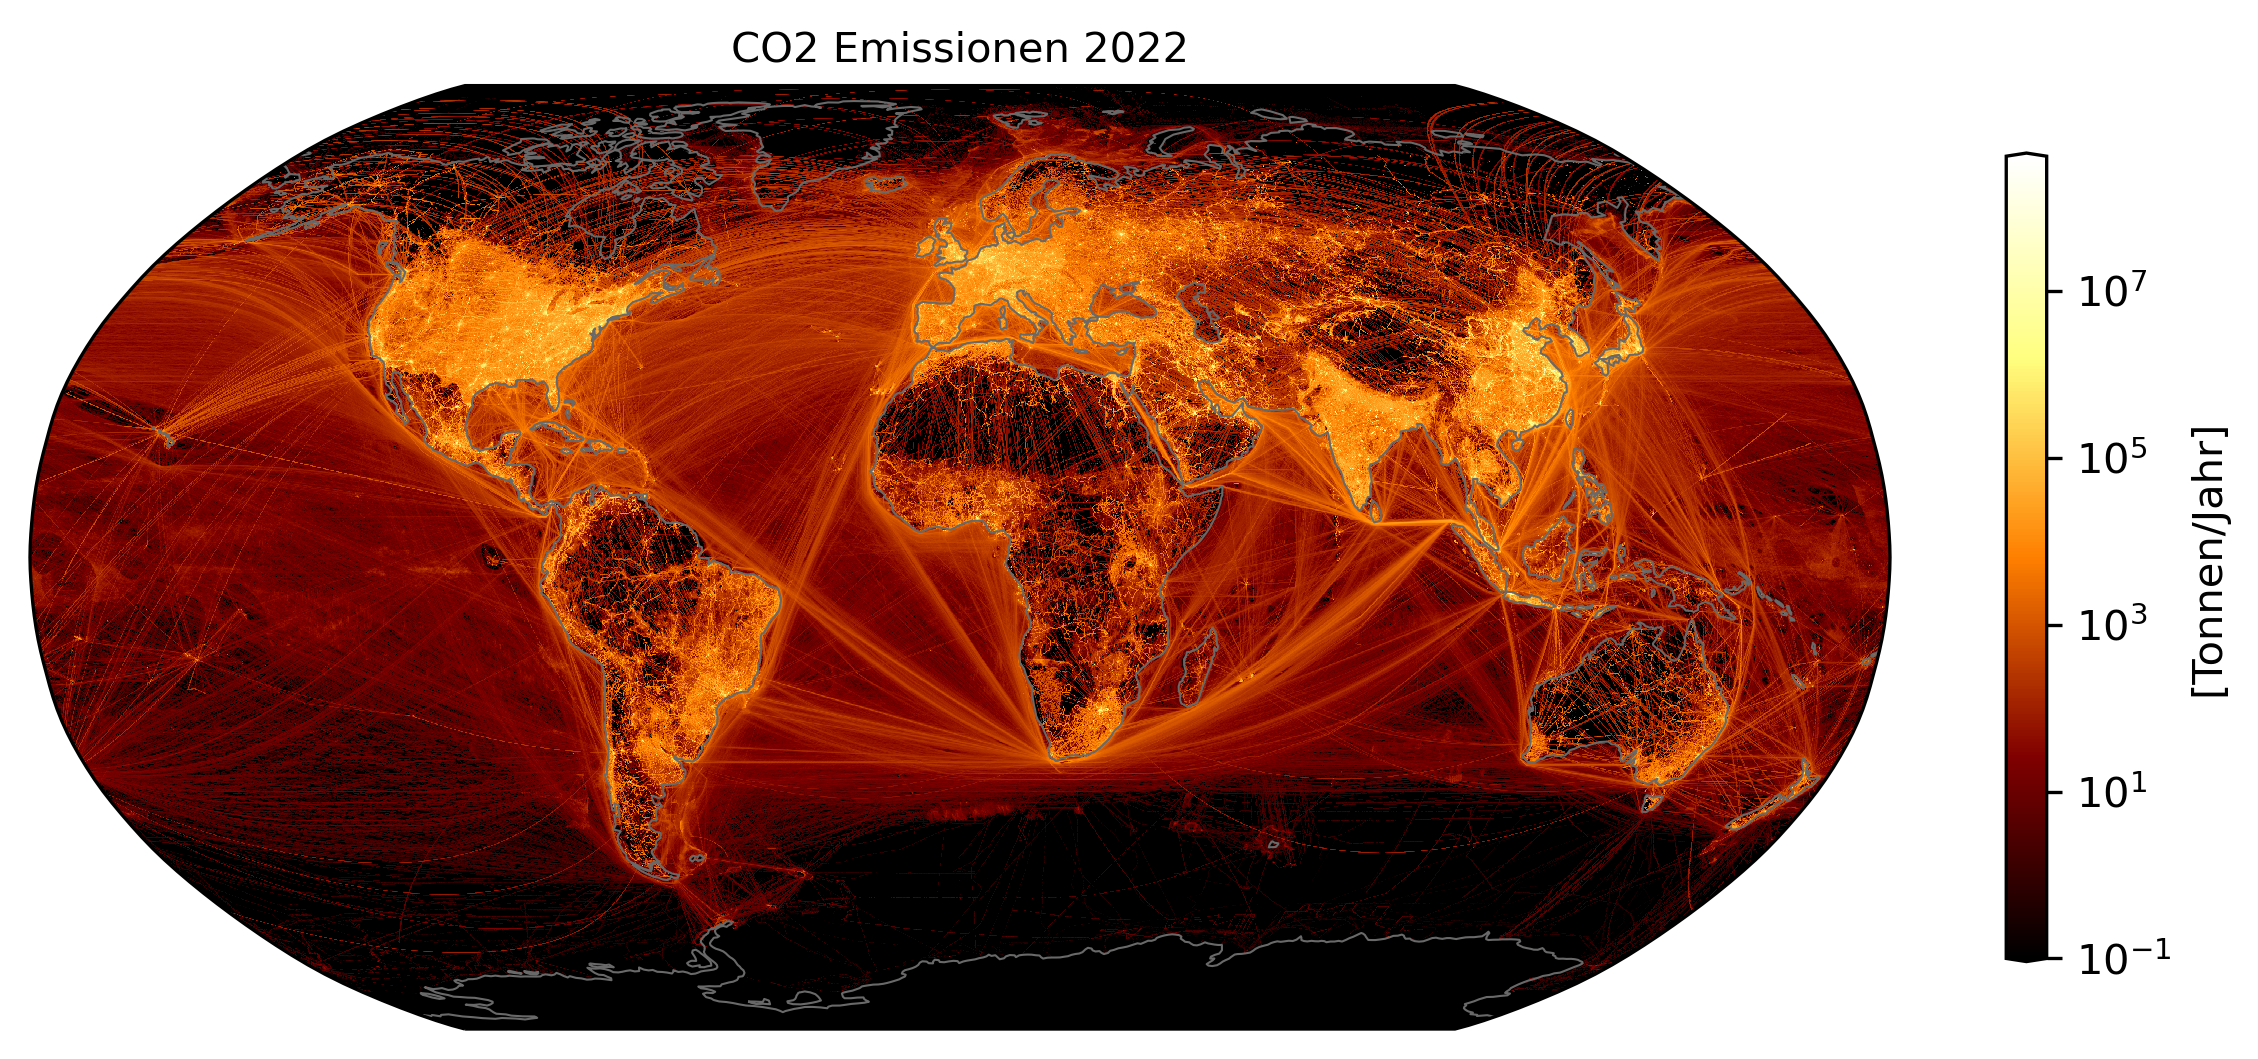

In [6]:


emissions_2022 = emissions_2022.compute()

fig, ax = plt.subplots(figsize=(10, 7),
    subplot_kw={'projection': ccrs.Robinson()},
    dpi=300
)
ax.patch.set_facecolor('black')

#logarithmic normalization
norm = LogNorm(vmin=max(emissions_2022.min(), 1e-1), vmax=emissions_2022.max())



# plot
mesh = ax.pcolormesh(lon, lat, emissions_2022, cmap='afmhot', norm=norm, transform=ccrs.PlateCarree())

# colorbar
cbar = fig.colorbar(mesh, ax=ax, orientation='vertical', extend='both', 
                    shrink=0.5, aspect=20,  #  Dicke anpassen
                    extendfrac='auto')  # Länge anpassen
cbar.set_label('[Tonnen/Jahr]', fontsize=10, color='black')


# coastlines and title
ax.coastlines(color='dimgray', linewidth=0.5)

plt.title('CO2 Emissionen 2022', fontsize=10, color='black')
#plt.savefig('CO2_2022.png', dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()



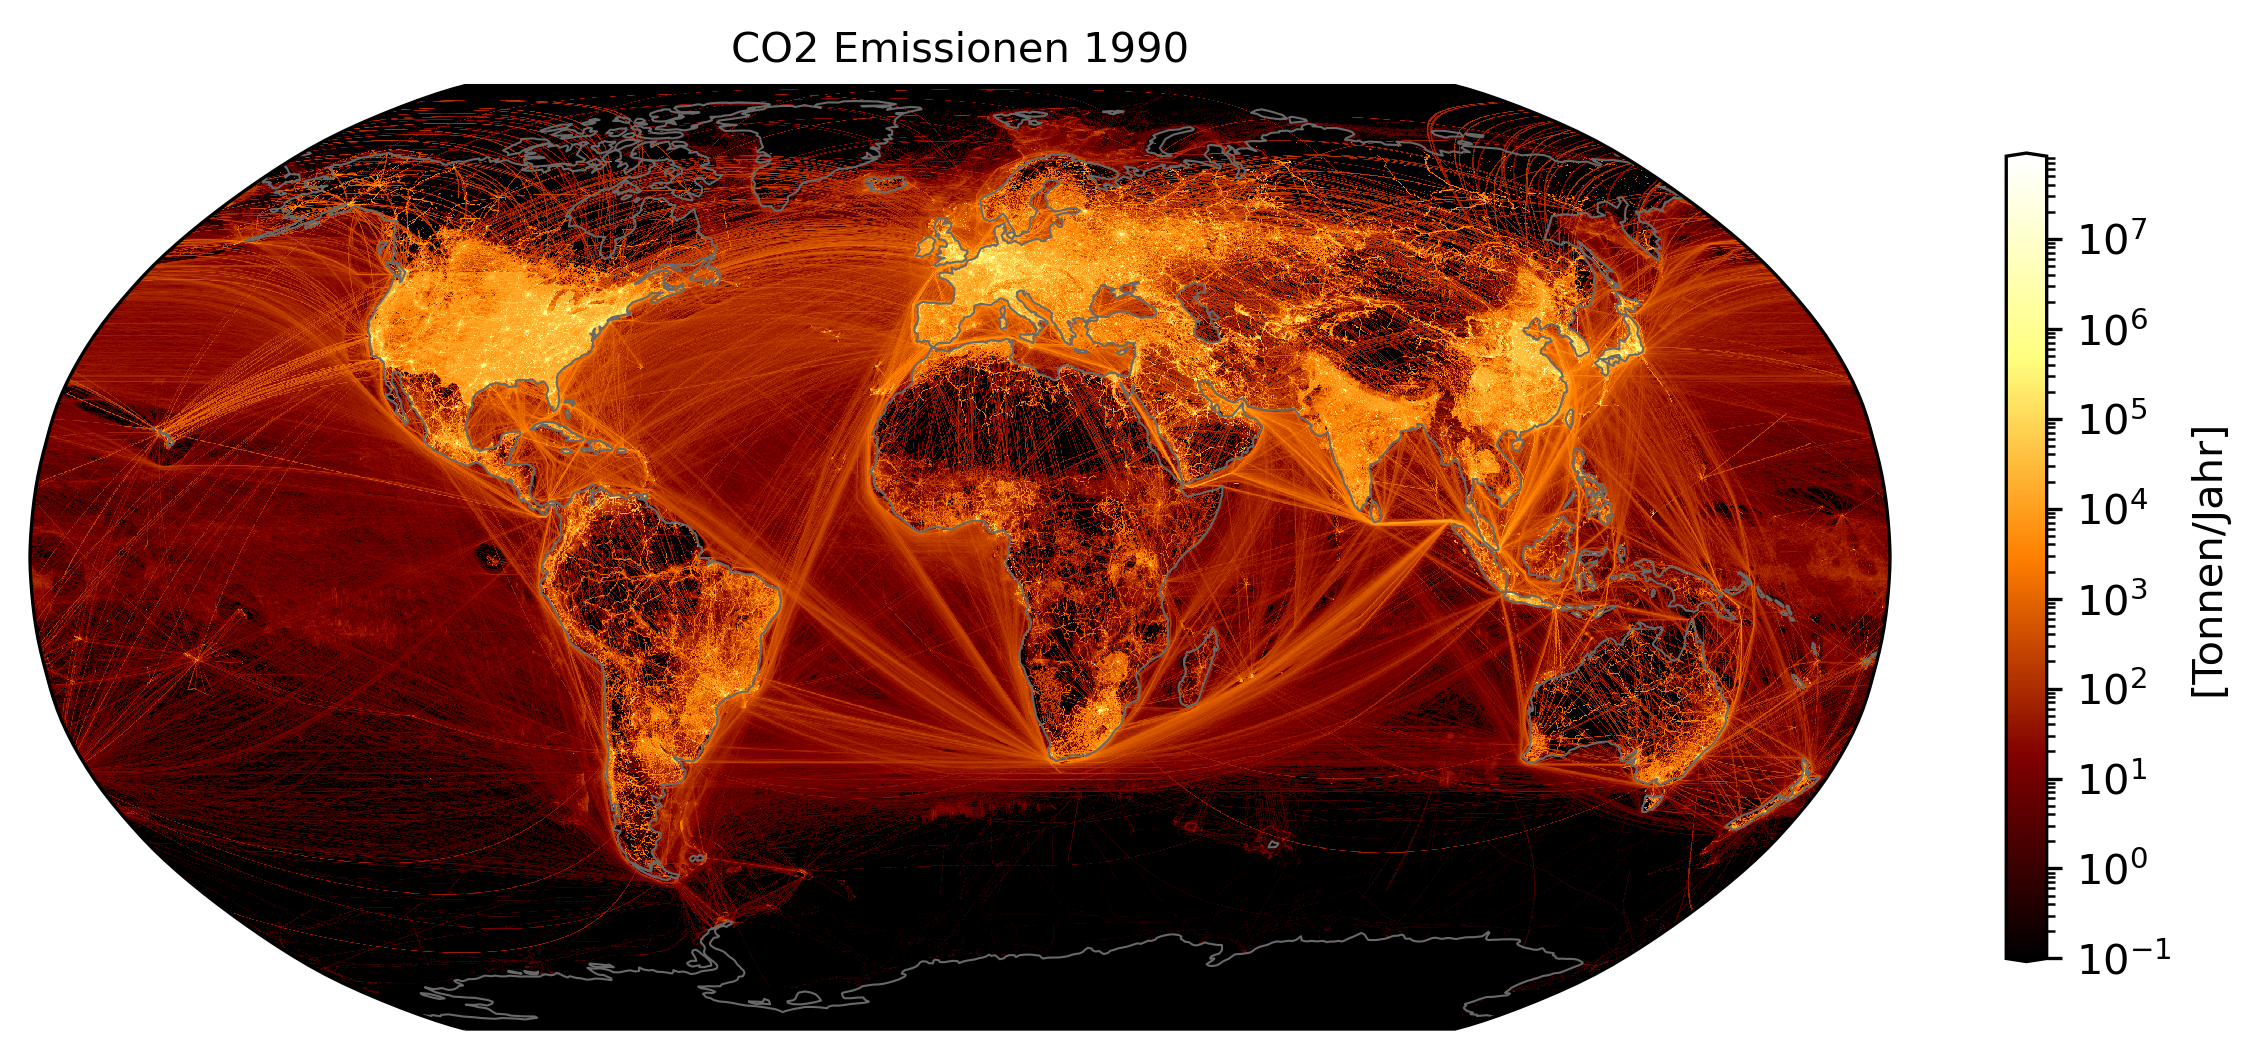

In [7]:


emissions_1990 = emissions_1990.compute()

fig, ax = plt.subplots(figsize=(10, 7),
    subplot_kw={'projection': ccrs.Robinson()},
    dpi=300
)
ax.patch.set_facecolor('black')

#logarithmic normalization
norm = LogNorm(vmin=max(emissions_1990.min(), 1e-1), vmax=emissions_1990.max())



# plot
mesh = ax.pcolormesh(lon, lat, emissions_1990, cmap='afmhot', norm=norm, transform=ccrs.PlateCarree())

# colorbar
cbar = fig.colorbar(mesh, ax=ax, orientation='vertical', extend='both', 
                    shrink=0.5, aspect=20,  #  Dicke anpassen
                    extendfrac='auto')  # Länge anpassen
cbar.set_label('[Tonnen/Jahr]', fontsize=10, color='black')



ax.coastlines(color='dimgray', linewidth=0.5)

plt.title('CO2 Emissionen 1990', fontsize=10, color='black')
#plt.savefig('CO2_2022.png', dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()



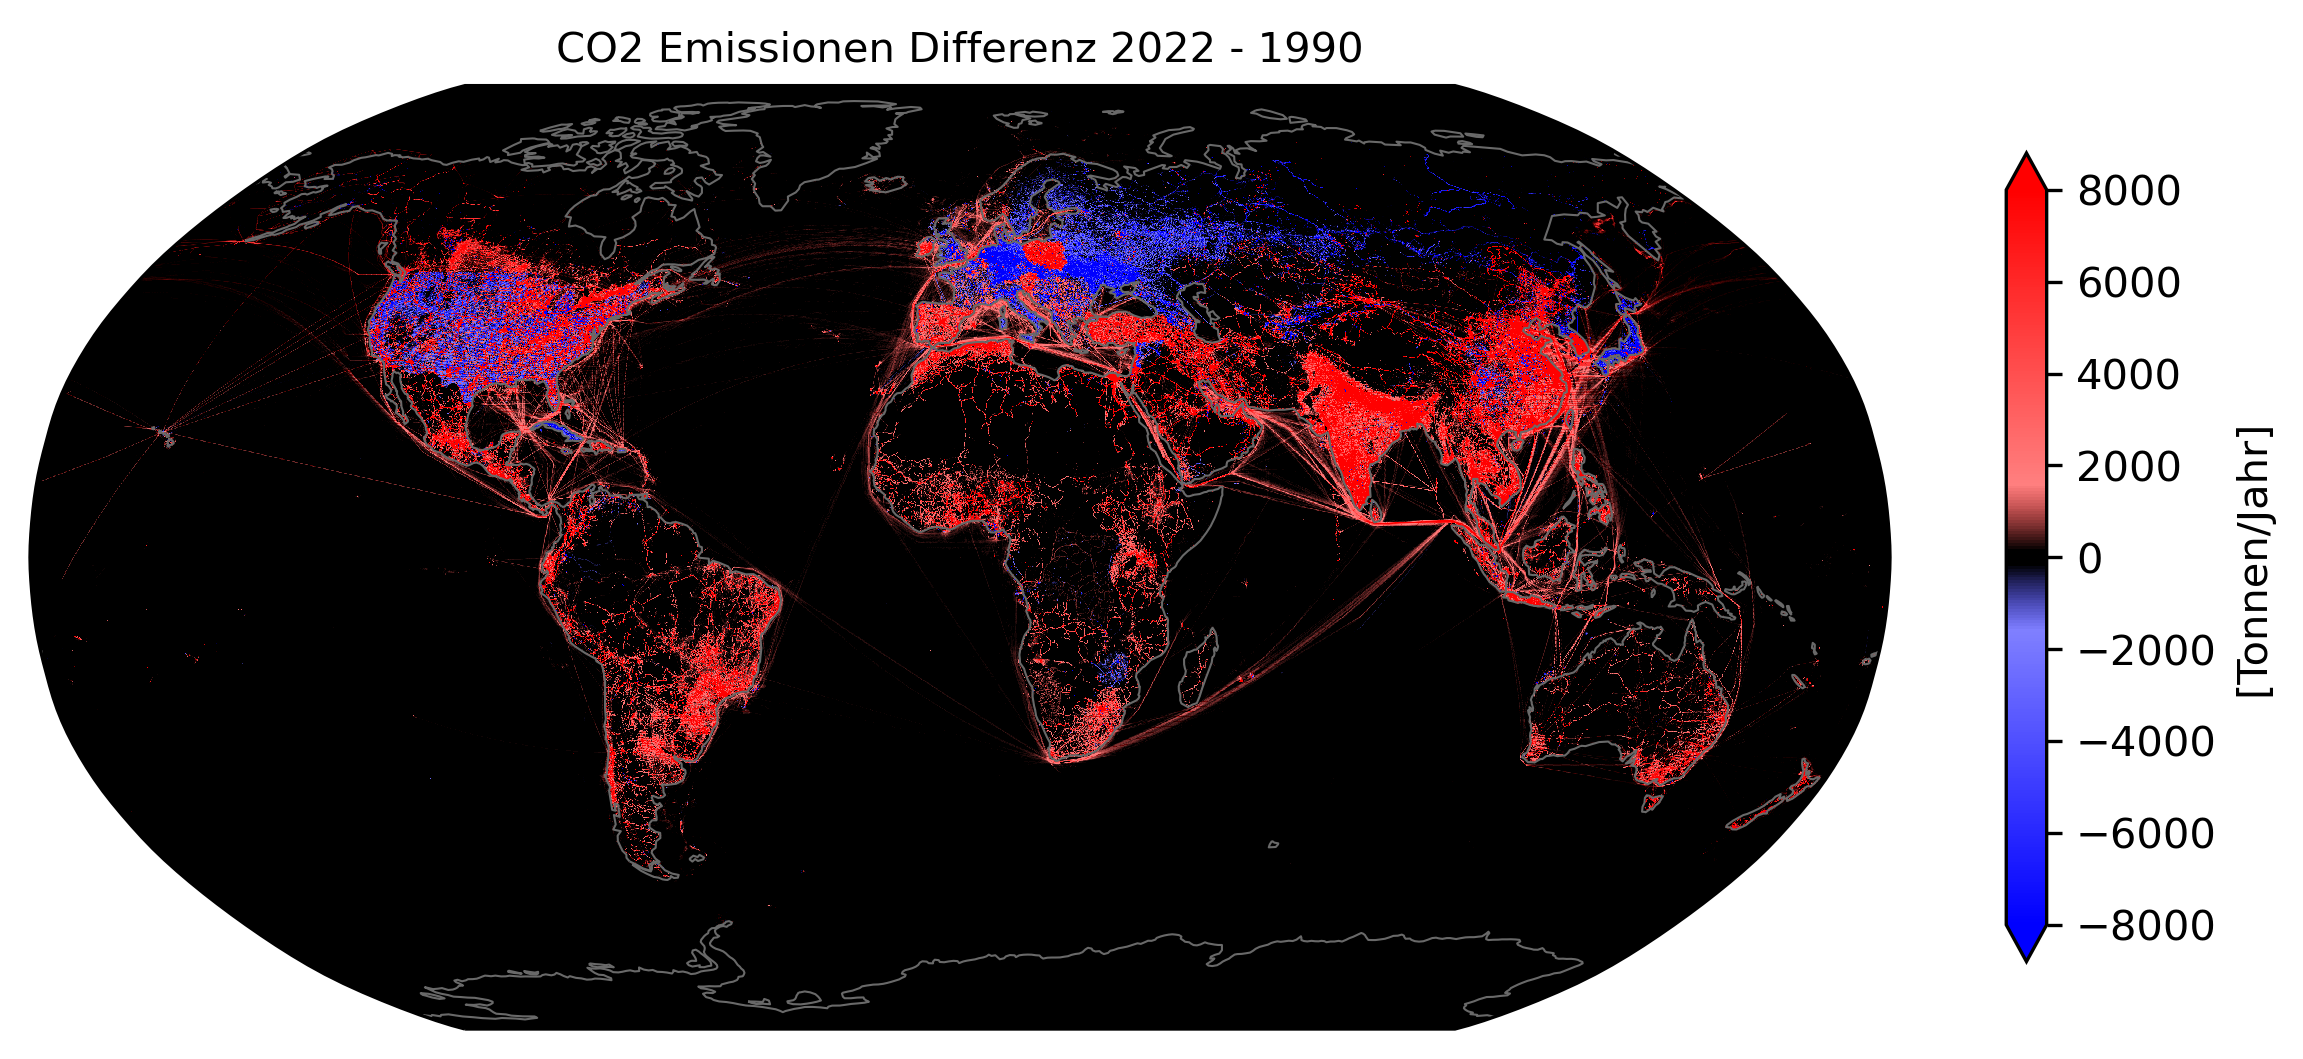

In [8]:


def make_colormap(seq):
    seq = [(None, *s) if len(s) == 2 else s for s in seq]
    cdict = {'red': [], 'green': [], 'blue': [], 'alpha': []}
    for pos, color, alpha in seq:
        r, g, b = mcolors.to_rgb(color)
        cdict['red'].append((pos, r, r))
        cdict['green'].append((pos, g, g))
        cdict['blue'].append((pos, b, b))
        cdict['alpha'].append((pos, alpha, alpha))
    return mcolors.LinearSegmentedColormap('CustomMap', cdict)

# define colormap
seq = [(0, 'blue', 1), (0.4, 'blue', 0.5), (0.49, 'black', 1), 
       (0.5, 'black', 1), (0.51, 'black', 1), (0.6, 'red', 0.5), 
       (1, 'red', 1)]

custom_cmap = make_colormap(seq)

# normalization
norm = mcolors.TwoSlopeNorm(vmin=-8000, vcenter=0, vmax=8000)


fig, ax = plt.subplots(figsize=(10, 7), subplot_kw={'projection': ccrs.Robinson()}, dpi=300)

# plot
mesh = ax.pcolormesh(lon, lat, emissions_diff, cmap=custom_cmap, norm=norm, transform=ccrs.PlateCarree())

# colorbar
cbar = fig.colorbar(mesh, ax=ax, orientation='vertical', extend='both', shrink=0.5)
cbar.set_label('[Tonnen/Jahr]', fontsize=10)

# coastlines and title
ax.coastlines(color='dimgray', linewidth=0.5)
plt.title('CO2 Emissionen Differenz 2022 - 1990', fontsize=10)

#
#plt.savefig('Diff_2022_1990_smooth_black.png', dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()



In [9]:
#df = (co2_2022-co2_1990)
#df.to_netcdf(r'Data\EDGAR_total_CO2_diff_2022_1990.nc')


In [10]:
#reas shapefile
countries_gdf = gpd.read_file(PATH_SHAPEFILE)

# convert in rioxarray-object
emissions_rio = ds_all['emissions'].rio.set_spatial_dims(x_dim='lon', y_dim='lat', inplace=True)
emissions_rio.rio.write_crs("epsg:4326", inplace=True)

# spatial aggregation
country_emissions = {}
for index, row in countries_gdf.iterrows():
    country_name = row['NAME']
    country_geom = row['geometry']
    try:
        clipped = emissions_rio.rio.clip([country_geom], countries_gdf.crs)
        country_emissions[country_name] = clipped.sum(dim=['lat', 'lon'])
    except rioxarray.exceptions.NoDataInBounds:
        print(f"No data for {country_name}.")
 

No data for Sint Maarten.
No data for Monaco.
No data for USNB Guantanamo Bay.
No data for Brazilian I..
No data for Gibraltar.
No data for Vatican.
No data for Pitcairn Is..
No data for U.S. Minor Outlying Is..
No data for Montserrat.
No data for St-Barthélemy.
No data for Indian Ocean Ter..
No data for Br. Indian Ocean Ter..
No data for Tuvalu.
No data for Nauru.
No data for Coral Sea Is..
No data for Spratly Is..
No data for Clipperton I..
No data for Ashmore and Cartier Is..
No data for Bajo Nuevo Bank.
No data for Serranilla Bank.
No data for Scarborough Reef.


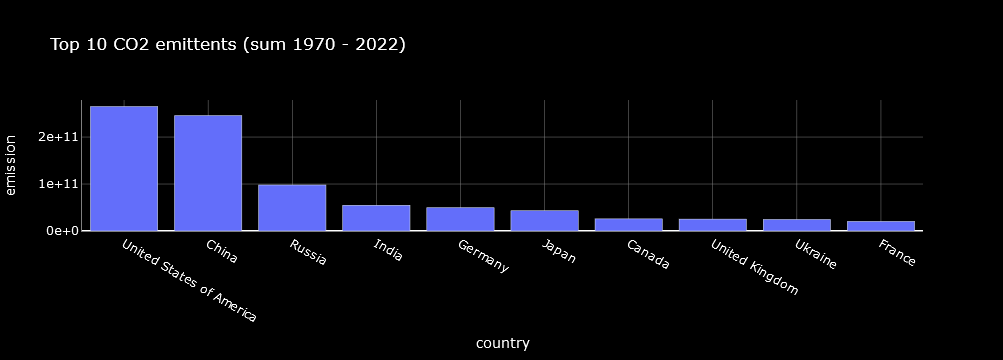

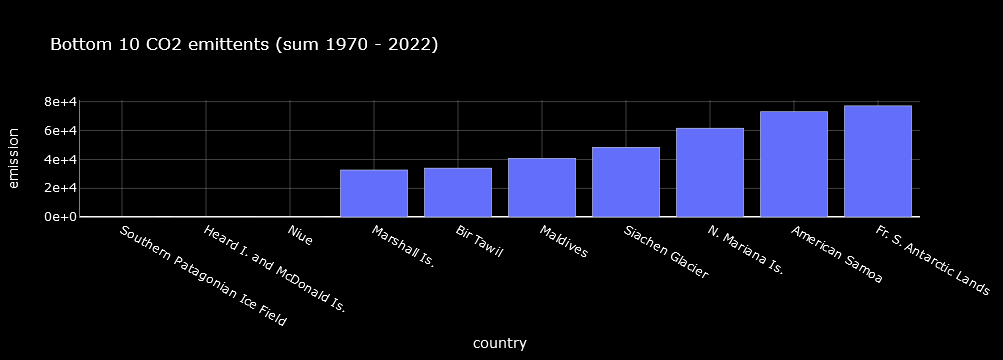

In [17]:

data = []
for country, emissions in country_emissions.items():
    # extract yearly emissions by country
    annual_emissions = emissions.values
    for year, emission in zip(range(1970, 2023), annual_emissions):
        data.append({'country': country, 'year': year, 'emission': emission})

# get dataframe
df_emissions = pd.DataFrame(data)

# sort data
top_10_emitters = df_emissions.groupby('country')['emission'].sum().nlargest(10)
bottom_10_emitters = df_emissions.groupby('country')['emission'].sum().nsmallest(10)

top_10_emitters = top_10_emitters.reset_index()
bottom_10_emitters = bottom_10_emitters.reset_index()

# plotly diagram for top 10 emittents
fig_top = px.bar(top_10_emitters, x='country', y='emission', title='Top 10 CO2 emittents (sum 1970 - 2022)')
fig_top.update_layout(
    plot_bgcolor='black',
    paper_bgcolor='black',
    font_color='white',
    xaxis=dict(showgrid=True, gridcolor='grey', gridwidth=0.5),
    yaxis=dict(showgrid=True, gridcolor='grey', gridwidth=0.5, tickformat='.0e')
)
fig_top.update_xaxes(showline=True, linewidth=1, linecolor='grey')
fig_top.update_yaxes(showline=True, linewidth=1, linecolor='grey')

fig_top.show()

# plotly diagram for bottom 10 emittents
fig_bottom = px.bar(bottom_10_emitters, x='country', y='emission', title='Bottom 10 CO2 emittents (sum 1970 - 2022)')
fig_bottom.update_layout(
    plot_bgcolor='black',
    paper_bgcolor='black',
    font_color='white',
    xaxis=dict(showgrid=True, gridcolor='grey', gridwidth=0.5),
    yaxis=dict(showgrid=True, gridcolor='grey', gridwidth=0.5, tickformat='.0e')
)
fig_bottom.update_xaxes(showline=True, linewidth=1, linecolor='grey')
fig_bottom.update_yaxes(showline=True, linewidth=1, linecolor='grey')

fig_bottom.show()

In [12]:
# global yearly mean
df_global_mean = df_emissions.groupby('year')['emission'].mean().reset_index()

# rename column
df_global_mean.rename(columns={'emission': 'global_mean_emission'}, inplace=True)

In [13]:
#choose  country
df_germany = df_emissions[df_emissions['country'] == 'Germany']
df_germany

country  year      emission
2544  Germany  1970  1.068870e+09
2545  Germany  1971  1.063415e+09
2546  Germany  1972  1.091566e+09
2547  Germany  1973  1.141558e+09
2548  Germany  1974  1.108140e+09
2549  Germany  1975  1.049455e+09
2550  Germany  1976  1.112271e+09
2551  Germany  1977  1.092069e+09
2552  Germany  1978  1.130249e+09
2553  Germany  1979  1.178553e+09
2554  Germany  1980  1.125530e+09
2555  Germany  1981  1.090945e+09
2556  Germany  1982  1.046221e+09
2557  Germany  1983  1.062778e+09
2558  Germany  1984  1.077793e+09
2559  Germany  1985  1.080448e+09
2560  Germany  1986  1.075672e+09
2561  Germany  1987  1.067378e+09
2562  Germany  1988  1.061125e+09
2563  Germany  1989  1.048405e+09
2564  Germany  1990  1.009398e+09
2565  Germany  1991  9.879663e+08
2566  Germany  1992  9.358099e+08
2567  Germany  1993  9.281476e+08
2568  Germany  1994  9.132923e+08
2569  Germany  1995  9.087158e+08
2570  Germany  1996  9.384489e+08
2571  Germany  1997  9.083425e+08
2572  Germany  1998  9.074204e+08
2573  Germany  1999  8.748907e+08
2574  Germany  2000  8.736456e+08
2575  Germany  2001  8.891312e+08
2576  Germany  2002  8.750454e+08
2577  Germany  2003  8.809039e+08
2578  Germany  2004  8.674961e+08
2579  Germany  2005  8.489306e+08
2580  Germany  2006  8.632064e+08
2581  Germany  2007  8.338742e+08
2582  Germany  2008  8.393069e+08
2583  Germany  2009  7.793130e+08
2584  Germany  2010  8.259745e+08
2585  Germany  2011  8.006907e+08
2586  Germany  2012  8.130639e+08
2587  Germany  2013  8.310164e+08
2588  Germany  2014  7.922216e+08
2589  Germany  2015  8.000356e+08
2590  Germany  2016  8.053139e+08
2591  Germany  2017  7.923898e+08
2592  Germany  2018  7.693179e+08
2593  Germany  2019  7.190132e+08
2594  Germany  2020  6.467112e+08
2595  Germany  2021  6.906461e+08
2596  Germany  2022  6.888426e+08

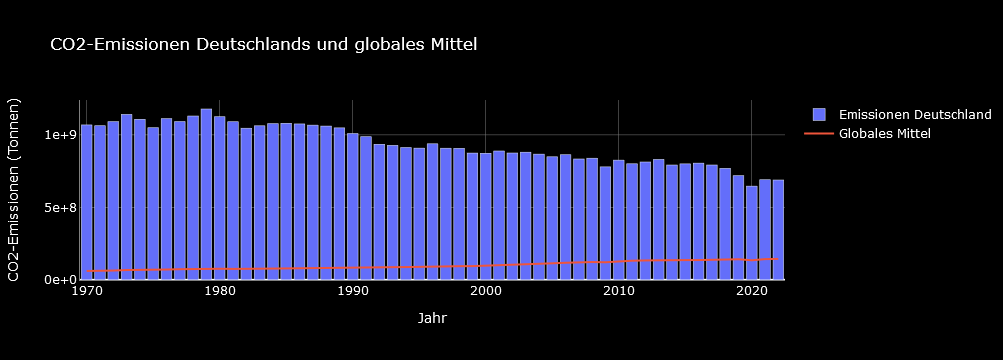

In [19]:

fig = go.Figure()

fig.add_trace(go.Bar(x=df_germany['year'], y=df_germany['emission'], name='Emissionen Deutschland'))
fig.add_trace(go.Scatter(x=df_global_mean['year'], y=df_global_mean['global_mean_emission'], name='Globales Mittel'))
fig.update_yaxes(exponentformat='e')
fig.update_layout(
    title='CO2-Emissionen Deutschlands und globales Mittel',
    xaxis_title='Jahr',
    yaxis_title='CO2-Emissionen (Tonnen)',
    plot_bgcolor='black',
    paper_bgcolor='black',
    font_color='white',
    xaxis=dict(showgrid=True, gridcolor='grey', gridwidth=0.5),
    yaxis=dict(showgrid=True, gridcolor='grey', gridwidth=0.5, tickformat='.0e')
)
fig.update_xaxes(showline=True, linewidth=1, linecolor='grey')
fig.update_yaxes(showline=True, linewidth=1, linecolor='grey')

fig.show()
